In [1]:
import csv
import numpy as np
#
# This function loads a COHPCAR file as produced by the electronic structure
# analysis tool LOBSTER, http://schmeling.ac.rwth-aachen.de/cohp/ to enable
# versatile plotting, rapid comparison between different calculations, etc.
# 
# The format does not have a formal specification, but the following holds
# for both lobster 3.2.0 and 4.0.0:
# Line 1 is a comment about energy shifts and can be ignored
# The first number of line 2 is the number of parial Crystal Orbital 
#  Hamiltonian Populations (pCOHPs) that are present in the file, which
#  we call Ncohps.
# Lines 3 to 3+Ncohps-1 are the atom pairs considered for each pCOHP
# Lines 3+Ncohps to the end of the file contain all pCOHPs and integrated pCOHPs
#  (ipCOHPs). Each line contains the energy (in eV), followed by (pCOHP,ipCOHP)
#  pairs for each atom pair. All numbers are in fortran block style, separated
#  by a variable number of spaces depending on whether or not the next number is
#  negative.
#
# This function uses the standard python CSV module to read the file,
# using a map over the input to remove consecutive spaces to make numbers separated
# by a single space, and configuring the reader to use a single space as the delimiter.
#
# The pCOHPs and ipCOHPs are returned as a dictionary of dictionary of arrays:
# dict[pair name] -> dict(pCOHP->array ipCOHP->array)
# each array contains two columns, energy and pCOHP/ipCOHP value respectively.
#
def load_cohp(file):
    with open(file, newline='') as f:
        def condenser(x):
            rv = x
            while '  ' in rv:
                rv = rv.replace('  ', ' ')
            rv = rv.strip()
            return rv
        rdr = csv.reader(map(condenser,f), delimiter=' ')
        line = 0
        cohps = []
        energy = []
        cohpsvals = []
        ncohps = 0
        for r in rdr:
            line += 1
            if line == 2:
                ncohps = int(r[0])
            if line >= 3 and line < 3+ncohps:
                # cohp label
                cohps.append(r[0])
            if line >= 3+ncohps:
                # data
                if len(r) != 2*ncohps+1:
                    raise ValueError("Incorrect number of pCOHP/ipCOHP values on line " + str(line))
                energy.append(float(r[0]))
                cohpsvals.append([float(i) for i in r[1:]])
    cohpsvals = np.array(cohpsvals)
    rv = {}
    for i in range(0,ncohps):
        rv[cohps[i]] = {'pCOHP': np.stack((energy,cohpsvals[:,2*i])).T, 'ipCOHP': np.stack((energy,cohpsvals[:,2*i+1])).T}
    return rv

In [2]:
# Laoding a COHPCAR is as simple as calling load_cohp
cohp = load_cohp('COHPCAR.lobster')

<IPython.core.display.Javascript object>


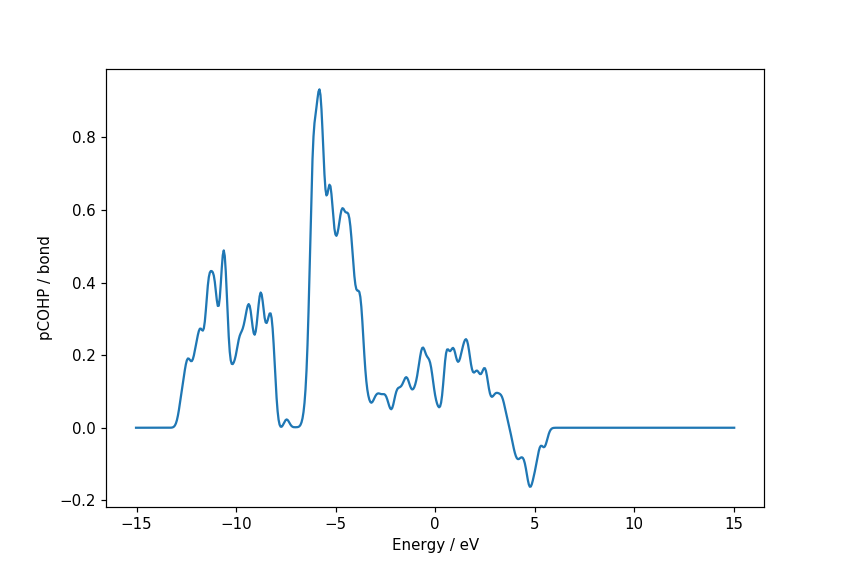

In [3]:
#
# This shows an example of selecting the (energy,pCOHP) values for a single
# pair (the "Average" pair) and plotting for immediate visualization.
#
%matplotlib notebook
import matplotlib.pyplot as plt
plt.xlabel('Energy / eV')
plt.ylabel('pCOHP / bond')
plt.plot(cohp['Average']['pCOHP'][:,0],cohp['Average']['pCOHP'][:,1])


<IPython.core.display.Javascript object>


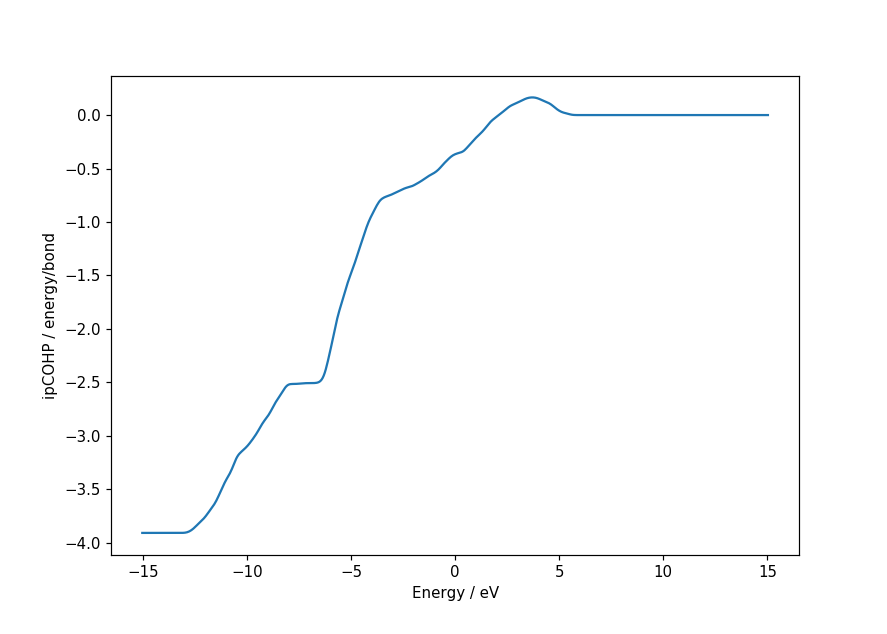

In [4]:
#
# This shows an example of selecting the (energy,ipCOHP) values for a single
# pair (the "Average" pair) and plotting for immediate visualization.
#
%matplotlib notebook
import matplotlib.pyplot as plt
plt.xlabel('Energy / eV')
plt.ylabel('ipCOHP / energy/bond')
plt.plot(cohp['Average']['ipCOHP'][:,0],cohp['Average']['ipCOHP'][:,1])


<IPython.core.display.Javascript object>


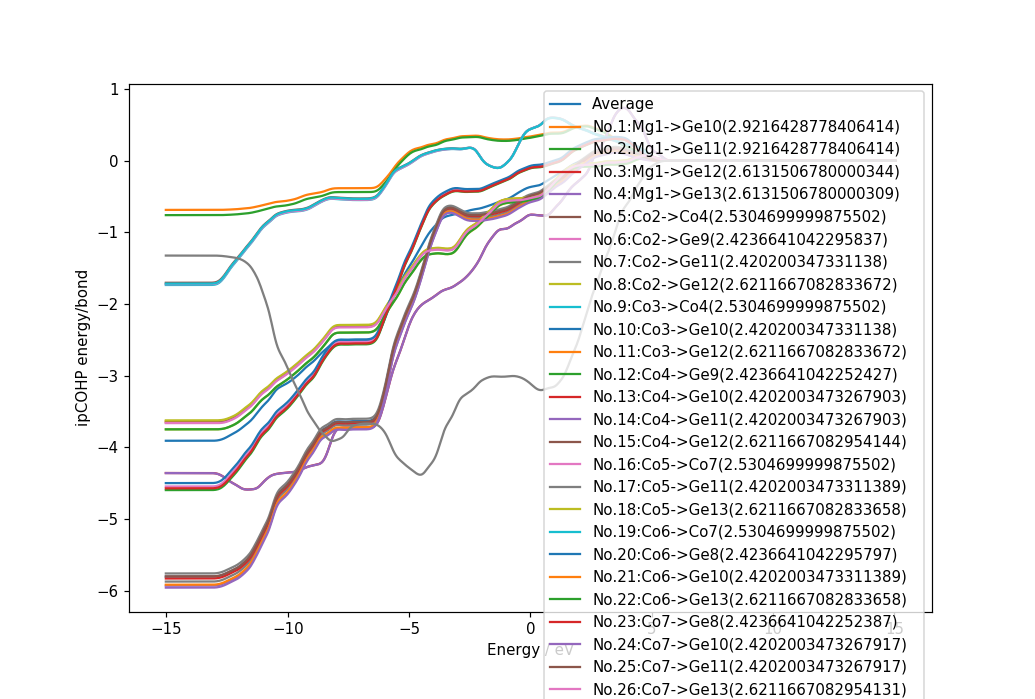

In [5]:
#
# This shows an example of plotting the ipCOHPs for all pairs from
# the file.
#
%matplotlib notebook
import matplotlib.pyplot as plt
for k in cohp:
    plt.plot(cohp[k]['ipCOHP'][:,0],cohp[k]['ipCOHP'][:,1], label=k)
plt.xlabel('Energy / eV')
plt.ylabel('ipCOHP energy/bond')
plt.legend()